# Advanced ML: Домашнее задание 2

Николай Горев

Группа MADE-DS-22

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**1.** Скачайте данные в формате csv, выберите из таблицы данные по России, начиная
с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве
целевой переменной возьмём число случаев заболевания (столбцы total_cases и
new_cases); для упрощения обработки можно заменить в столбце new_cases все
нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в
виде первых 60 отсчётов (дней), начиная с 3 марта; остальные данные можно
использовать в качестве тестового набора (и он даже будет увеличиваться по мере
выполнения задания).

In [2]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
raw_data = pd.read_csv(url, parse_dates=['date'])

In [3]:
data = raw_data[(raw_data.location == 'Russia') & (raw_data.date >= '2020-03-03')][['date', 'total_cases', 'new_cases']]
data.reset_index(drop=True, inplace=True)

data['x'] = data.index
data.loc[data.new_cases == 0, "new_cases"] = 1

In [4]:
data.head()

,date,total_cases,new_cases,x
0,2020-03-03,3,1,0
1,2020-03-04,4,1,1
2,2020-03-05,4,1,2
3,2020-03-06,4,1,3
4,2020-03-07,10,6,4


In [5]:
train = data[:60]
test = data[60:]

**2.** Постройте графики целевых переменных. Вы увидите, что число заболевших
растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к
снаряду давайте это и используем.

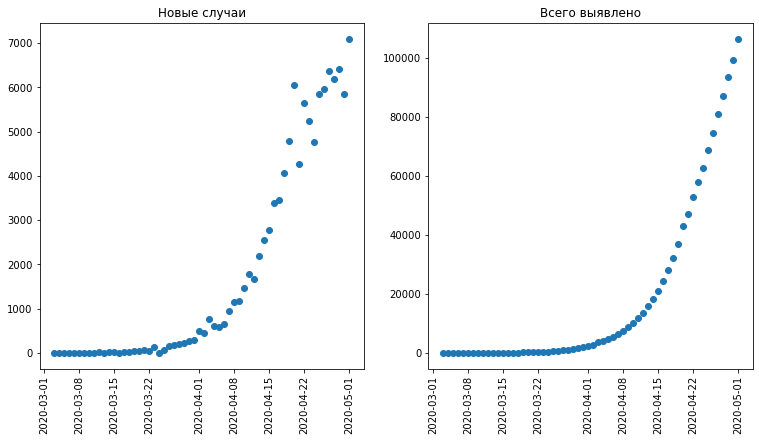

In [6]:
plt.figure(figsize=(12, 6))
plt.subplots_adjust(right=0.95, bottom=0.1, top=0.9)
ax = plt.subplot(121)
plt.scatter(train.date, train.new_cases)
plt.xticks(rotation=90) 
plt.title('Новые случаи')
ax = plt.subplot(122)
plt.scatter(train.date, train.total_cases)
plt.xticks(rotation=90) 
plt.title('Всего выявлено')
plt.show()

**a.** Используя линейную регрессию, обучите модель с экспоненциальным
ростом числа заболевших: *y ~ exp(линейная функция от x)* , где x — номер
текущего дня.

Будем аппроксимировать линейной регрессией логарифм целевой переменной. Сначала просто воспользуемся линейной регрессией из пакета `scikit learn`

In [7]:
log_y_new = np.log(train.new_cases)
X = np.asarray(train.x).reshape(-1, 1)
model_new_cases = linear_model.LinearRegression(fit_intercept=True).fit(X, log_y_new)

In [8]:
log_y_total = np.log(train.total_cases)
model_total_cases = linear_model.LinearRegression(fit_intercept=True).fit(X, log_y_total)

Графики для логарифмов

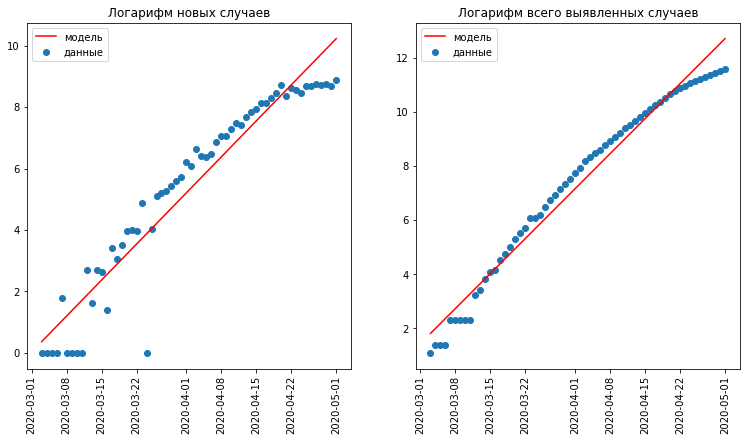

In [9]:
plt.figure(figsize=(12, 6))
plt.subplots_adjust(right=0.95, bottom=0.1, top=0.9)
ax = plt.subplot(121)
plt.scatter(train.date, log_y_new, label='данные')
plt.plot(train.date, model_new_cases.predict(X), 
         color='r', label='модель')
plt.xticks(rotation=90) 
plt.title('Логарифм новых случаев')
plt.legend()
ax = plt.subplot(122)
plt.scatter(train.date, log_y_total, label='данные')
plt.plot(train.date, model_total_cases.predict(X), 
         color='r', label='модель')
plt.xticks(rotation=90) 
plt.title('Логарифм всего выявленных случаев')
plt.legend()
plt.show()

Графики в исходных переменных

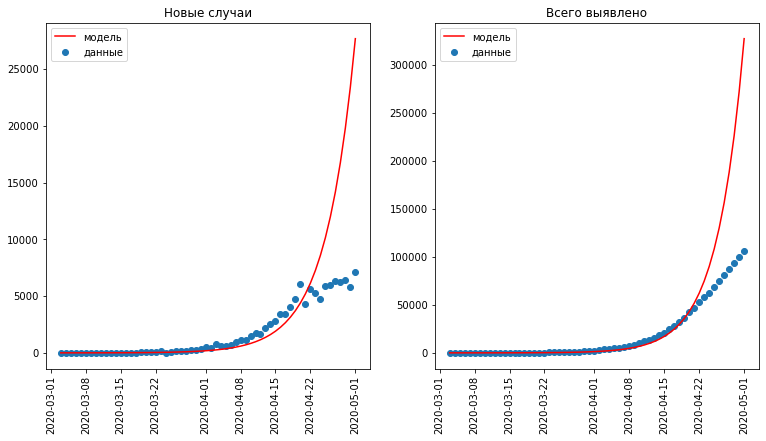

In [10]:
plt.figure(figsize=(12, 6))
plt.subplots_adjust(right=0.95, bottom=0.1, top=0.9)
ax = plt.subplot(121)
plt.scatter(train.date, train.new_cases, label='данные')
plt.plot(train.date, np.exp(model_new_cases.predict(X)), 
         color='r', label='модель')
plt.xticks(rotation=90) 
plt.title('Новые случаи')
plt.legend()
ax = plt.subplot(122)
plt.scatter(train.date, train.total_cases, label='данные')
plt.plot(train.date, np.exp(model_total_cases.predict(X)), 
         color='r', label='модель')
plt.xticks(rotation=90) 
plt.title('Всего выявлено')
plt.legend()
plt.show()

**b.** Найдите апостериорное распределение параметров этой модели для
достаточно широкого априорного распределения. Требующееся для этого
значение дисперсии шума в данных оцените, исходя из вашей же
максимальной апостериорной модели (это фактически первый шаг
эмпирического Байеса).

Модель - $cases = \exp(a + b \cdot x)$ или $y = \log(cases) = a + b \cdot x$.

Параметры модели - $w = [a, b]$

Будем считать, что априорное распределение параметров - нормальное с нулевым средним и диагональной матрицей дисперсий с диагональными элементами равными 10.

In [11]:
# вычисление параметров апостериорного распределения параметров модели
# m_0, sigma_0 - параметры априорного распределения
def bayesian_update(mu_0, sigma_0, X, y, beta):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma_0) + 
                            beta * np.matmul(np.transpose(X), X))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma_0), np.transpose(mu_0)) + 
                     beta * np.matmul(np.transpose(X), np.array(y)))
    return mu_n, sigma_n

def calculate_aposterior(X, y, beta_0):
    X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    
    # параметры априорного распределения
    d = X.shape[1]
    mu_0 = np.zeros(d)
    sigma_0 = 10 * np.eye(d)
    
    beta = beta_0
    beta_prev = beta
    while True:
        mu_n, sigma_n = bayesian_update(mu_0, sigma_0, X, y, beta)
        predictions = np.matmul(X, mu_n)
        beta = 1 / np.var(y - predictions)
        if abs(beta - beta_prev) < 1.e-8:
            break
        else:
            beta_prev = beta
    return mu_n, sigma_n, beta

In [12]:
beta_0 = 1 / np.var(log_y_new - model_new_cases.predict(X))
mu_n_new_cases, sigma_n_new_cases, beta_new_cases = calculate_aposterior(X, log_y_new, beta_0)

beta_0 = 1 / np.var(log_y_total - model_total_cases.predict(X))
mu_n_total_cases, sigma_n_total_cases, beta_total_cases = calculate_aposterior(X, log_y_total, beta_0)

**c.** Посэмплируйте много разных экспонент, постройте графики. Сколько,
исходя из этих сэмплов, предсказывается случаев коронавируса в России к
1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения
(можно эмпирически, исходя из данных сэмплирования).

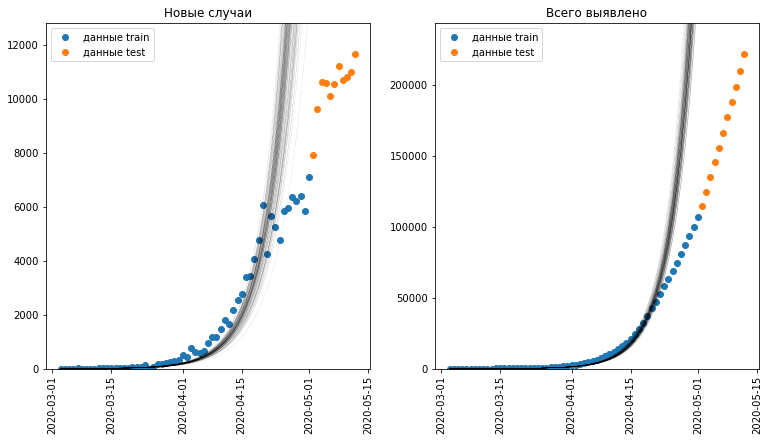

In [13]:
n_samples = 100
plt.figure(figsize=(12, 6))
plt.subplots_adjust(right=0.95, bottom=0.1, top=0.9)
ax = plt.subplot(121)

# Посэмплируем и порисуем экспоненты
xd = np.append(train.date, test.date)
xs = np.arange(len(xd))
my_w = np.random.multivariate_normal(mu_n_new_cases, sigma_n_new_cases, n_samples)
for w in my_w:
    plt.plot(xd, np.exp(w[0] + w[1]*xs), 'k-', lw=.05)

plt.scatter(train.date, train.new_cases, label='данные train')
plt.scatter(test.date, test.new_cases, label='данные test')
    
plt.xticks(rotation=90) 
plt.title('Новые случаи')
plt.legend()
plt.ylim((0, np.max(test.new_cases) * 1.1))

ax = plt.subplot(122)

# Посэмплируем и порисуем экспоненты
my_w = np.random.multivariate_normal(mu_n_total_cases, sigma_n_total_cases, n_samples)
for w in my_w:
    plt.plot(xd, np.exp(w[0] + w[1]*xs), 'k-', lw=.05)

plt.scatter(train.date, train.total_cases, label='данные train')
plt.scatter(test.date, test.total_cases, label='данные test')

plt.xticks(rotation=90) 
plt.title('Всего выявлено')
plt.legend()
plt.ylim((0, np.max(test.total_cases) * 1.1))

plt.show()

Прогноз логарифма имеет нормальное распределение с параметрами: 

- среднее $\mu_N^\top X$
- дисперсия $\frac{1}{\beta} + X^\top \Sigma_N X$

In [14]:
# Построение предсказательного распределения
def buildPredictiveDist(mu_n, sigma_n, beta, x, n_samples=100000):
    map_pred = np.matmul(x, np.transpose(mu_n))
    sigma = 1 / beta + np.matmul(x, np.matmul(sigma_n, np.transpose(x)))
    log_samples = np.random.normal(map_pred, sigma, n_samples)
    return np.exp(log_samples)

Прогнозы новых случаев

Прогноз на дату: 2020-05-01
Медиана прогноза по сэмплам =  27487.34162490022


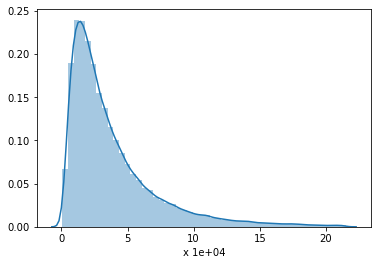

Прогноз на дату: 2020-06-01
Медиана прогноза по сэмплам =  4965013.11028048


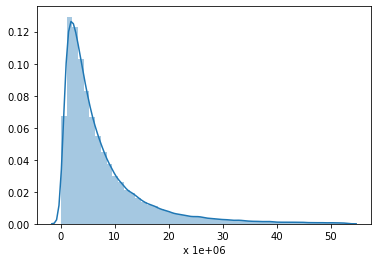

Прогноз на дату: 2020-09-01
Медиана прогноза по сэмплам =  23818440056595.25


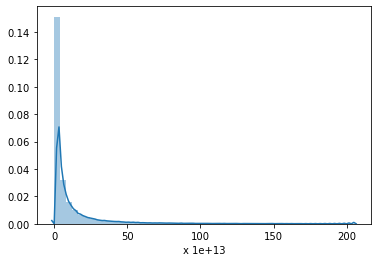

In [15]:
dates = [pd.Timestamp(year=2020, month=5, day=1),
         pd.Timestamp(year=2020, month=6, day=1),
         pd.Timestamp(year=2020, month=9, day=1)]
for date in dates:
    print('Прогноз на дату: {:}'.format(date.date()))
    day = (date - train.date[0]).days
    x = np.array([1, day])
    samples = buildPredictiveDist(mu_n_new_cases, sigma_n_new_cases, beta_new_cases, x)
    
    print('Медиана прогноза по сэмплам = ', np.median(samples))
    
    # отфильтруем выбросы
    samples = samples[samples <= np.percentile(samples, 99)]
    
    norm_const = 10 ** np.floor(np.log10(samples.mean()))
    sns.distplot(samples / norm_const);
    plt.xlabel("x {:.0e}".format(norm_const))
    plt.show()

Прогнозы общего количества случаев

Прогноз на дату: 2020-05-01
Медиана прогноза по сэмплам =  327864.9072903389


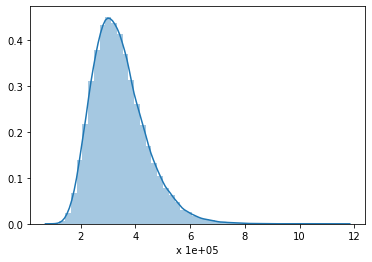

Прогноз на дату: 2020-06-01
Медиана прогноза по сэмплам =  100170896.61461027


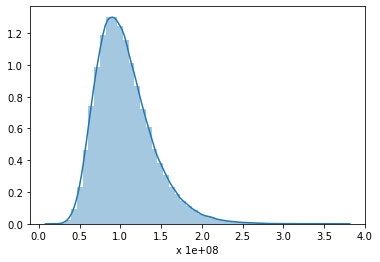

Прогноз на дату: 2020-09-01
Медиана прогноза по сэмплам =  2366392575346646.0


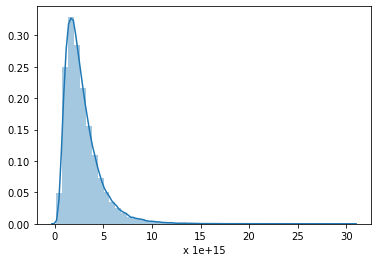

In [16]:
for date in dates:
    print('Прогноз на дату: {:}'.format(date.date()))
    day = (date - train.date[0]).days
    x = np.array([1, day])
    samples = buildPredictiveDist(mu_n_total_cases, sigma_n_total_cases, beta_total_cases, x)
    
    print('Медиана прогноза по сэмплам = ', np.median(samples))
    norm_const = 10 ** np.floor(np.log10(samples.mean()))
    sns.distplot(samples / norm_const);
    plt.xlabel("x {:.0e}".format(norm_const))
    plt.show()

**3.** Предсказания экспоненциальной модели наверняка получились грустными. Но это,
конечно, чересчур пессимистично — экспоненциальный рост в природе никак не
может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в
реальности имеет сигмоидальный вид: после начальной фазы экспоненциального
роста неизбежно происходит насыщение. В качестве конкретной формы такой
сигмоиды давайте возьмём форму функции распределения для гауссиана: $$ \Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-t^2/2} dt$$
Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа
перед интегралом может быть произвольной (и её можно внести в экспоненту), а в
экспоненте под интегралом может быть произвольная квадратичная функция от $t$.

**a.** Предложите способ обучать параметры такой сигмоидальной функции при
помощи линейной регрессии.

Непосредственно обучать сигмоидальную модель неудобно. 

Предлагается обучать модель для числа новых случаев вида: $new\; cases = \exp(a + b\cdot x + c\cdot x^2)$ , где $x$ — номер текущего дня. Оцениваем параметры линейной регрессии для логарифма $y = \log(new\;cases) = a + b\cdot x + c\cdot x^2$.

Общее число заболевших на данную дату можно определять двумя способами:

1. Как куммлятивную сумму от прогнозов модели для новых случаев: $total \; cases_n = \sum_{i=0}^n new\;cases_i$
2. Используя оцененные параметры модели для новых случаев - интегрируя экспоненту (в предположении $c < 0$): $$total \; cases_n = \int_{-\infty}^x new\;cases(t) dt = \int_{-\infty}^x\exp(a + b\cdot t + c \cdot t^2) dt = \sqrt{\frac{\pi}{|c|}}\exp\left( \frac{4ac-b^2}{4c}\right)\Phi\left(\frac{-2cx-b}{\sqrt{2|c|}}\right)$$

In [17]:
X = np.asarray(train.x).reshape(-1, 1)
X = np.concatenate((X, X ** 2), axis=1)

In [18]:
model2_new_cases = linear_model.LinearRegression(fit_intercept=True).fit(X, log_y_new)

In [19]:
from scipy.stats import norm

def predictSigmoid(x, w):
    a = w[0]
    b = w[1]
    c = w[2]
    return np.sqrt(np.pi / np.abs(c)) * np.exp((4 * a * c - b * b) / (4 * c)) *\
    norm.cdf((-2 * c * x - b) / np.sqrt(2 * np.abs(c)))

In [20]:
from datetime import timedelta
final_predict_date = pd.Timestamp(year=2020, month=7, day=1)
n_days = (final_predict_date - train.date[0]).days
pred_dates = np.array([train.date[0] + timedelta(days=i) for i in range(n_days)])
xs = np.arange(n_days).reshape(-1, 1)
xs = np.concatenate((xs, xs ** 2), axis=1)

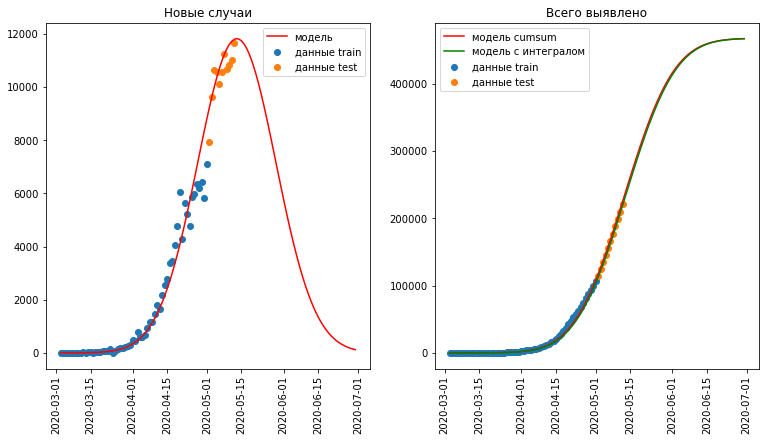

In [21]:
predictions = np.exp(model2_new_cases.predict(xs))
predictions_total_cumsum = np.cumsum(predictions)
w = np.array([model2_new_cases.intercept_] + list(model2_new_cases.coef_))
predictions_total_integral = predictSigmoid(xs[:,0], w)
plt.figure(figsize=(12, 6))
plt.subplots_adjust(right=0.95, bottom=0.1, top=0.9)
ax = plt.subplot(121)
plt.scatter(train.date, train.new_cases, label='данные train')
plt.scatter(test.date, test.new_cases, label='данные test')
plt.plot(pred_dates, predictions, 
         color='r', label='модель')
plt.xticks(rotation=90) 
plt.title('Новые случаи')
plt.legend()
ax = plt.subplot(122)
plt.scatter(train.date, train.total_cases, label='данные train')
plt.scatter(test.date, test.total_cases, label='данные test')
plt.plot(pred_dates, predictions_total_cumsum, 
         color='r', label='модель cumsum')
plt.plot(pred_dates, predictions_total_integral, 
         color='g', label='модель с интегралом')
plt.xticks(rotation=90) 
plt.title('Всего выявлено')
plt.legend()
plt.show()

Прогнозы моделей с куммулятивными суммами и с интегралом практически неотличимы. Будем использовать модель с интегралом, т.к. она в большей степени соответствует заданию.

**b.** Обучите эти параметры на датасете случаев коронавируса в России.
Найдите апостериорное распределение параметров этой модели для
достаточно широкого априорного распределения. Требующееся для этого
значение дисперсии шума в данных оцените, исходя из вашей же
максимальной апостериорной модели.

In [22]:
beta_0 = 1 / np.var(log_y_new - model2_new_cases.predict(X))
mu_n_new_cases, sigma_n_new_cases, beta_new_cases = calculate_aposterior(X, log_y_new, beta_0)

**c.** Посэмплируйте много разных сигмоид из апостериорного распределения,
постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев
коронавируса в России? Постройте эмпирическое предсказательное
распределение, нарисуйте графики. Каков ваш прогноз числа случаев
коронавируса в пессимистичном сценарии (90-й процентиль в выборке
числа случаев)? В оптимистичном сценарии (10-й процентиль)?

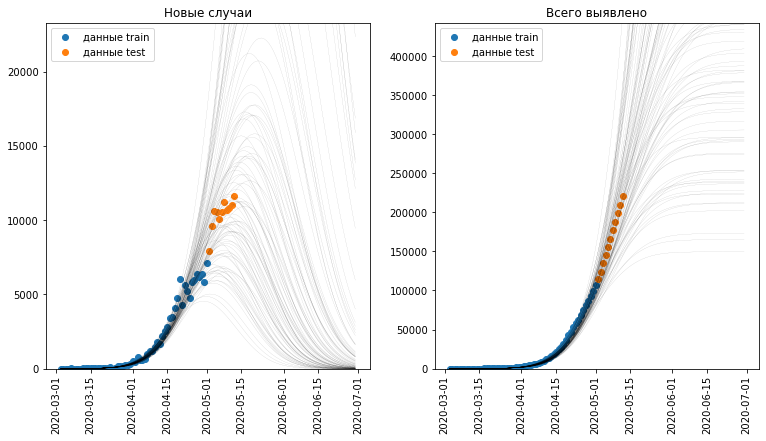

In [23]:
n_samples = 100

# Посэмплируем экспоненты
my_w = np.random.multivariate_normal(mu_n_new_cases, sigma_n_new_cases, n_samples)
predictions_new = []
predictions_total = []
x = xs[:, 0]
for w in my_w:
    predictions = np.exp(w[0] + w[1] * x + w[2] * x ** 2) 
    predictions_new.append(predictions)
    predictions_total.append(predictSigmoid(x, w))

plt.figure(figsize=(12, 6))
plt.subplots_adjust(right=0.95, bottom=0.1, top=0.9)
ax = plt.subplot(121)

for prediction in predictions_new:
    plt.plot(pred_dates, prediction, 'k-', lw=.05)

plt.scatter(train.date, train.new_cases, label='данные train')
plt.scatter(test.date, test.new_cases, label='данные test')

plt.xticks(rotation=90) 
plt.title('Новые случаи')
plt.legend()
plt.ylim((0, np.max(test.new_cases) * 2))

ax = plt.subplot(122)

for prediction in predictions_total:
    plt.plot(pred_dates, prediction, 'k-', lw=.05)

plt.scatter(train.date, train.total_cases, label='данные train')
plt.scatter(test.date, test.total_cases, label='данные test')

plt.xticks(rotation=90) 
plt.title('Всего выявлено')
plt.legend()
plt.ylim((0, np.max(test.total_cases) * 2))
plt.show()

Мы аппроксимировали логарифм количества новых случаев квадратичной функцией $\log(new\;cases) = y_i = a + b\cdot x_i + c \cdot x_i^2 + \varepsilon_i$, где $x_i$ - номер текущего дня, $\varepsilon_i \sim {\mathcal {N}}(0 ,\frac{1}{\beta})$ - шум.

Случайные величины $\varepsilon_i$ независимые для различных $i$ и независимы с $a$, $b$ и $c$.

При фиксированных параметрах  $a$, $b$ и $c$ общее число случаев $$T = \sum_i \exp(y_i) = \sum_i \exp(a + b\cdot x_i + c \cdot x_i^2 + \varepsilon_i) \approx \sum_i \exp(a + b\cdot x_i + c \cdot x_i^2) {\mathbb  {E}}[\exp(\varepsilon_i)] =  $$
$$ = \sum_i \exp(a + \frac{1}{2\beta} + b\cdot x_i + c \cdot x_i^2) \approx \int_{-\infty}^{\infty}\exp(a + \frac{1}{2\beta} + b\cdot t + c \cdot t^2) dt = \sqrt{\frac{\pi}{|c|}}\exp\left( \frac{4(a + \frac{1}{2\beta})c-b^2}{4c}\right)$$

Сэмплируя параметры линейной регрессии из найденного распределения параметров линейной регрессии, получаем сэмплы общего количества случаев коронавируса.

Сэмплируя выше сигмоиды из апостериорного распределения, построенного на тренировочном наборе данных, мы видели сильный разброс, растущий со временем. Это связано с тем, что ошибка прогноза линейной регрессии растет по мере удаления от данных, использованных при построении модели. А потом мы еще вычисляем экспоненту, что приводит к взрывному росту ошибки прогноза.

Чтобы получить максимально точный прогноз используем для построения модели все доступные данные, а не только тренировочный набор.

In [24]:
# используем все данные
X = np.asarray(data.x).reshape(-1, 1)
X = np.concatenate((X, X ** 2), axis=1)
log_y_new = np.log(data.new_cases)
mu_n_new_cases, sigma_n_new_cases, beta_new_cases = calculate_aposterior(X, log_y_new, beta_new_cases)

In [25]:
def sampleTotal(mu_n_new_cases, sigma_n_new_cases, beta, n_samples=100000):
    w = np.random.multivariate_normal(mu_n_new_cases, sigma_n_new_cases, n_samples)
    a = w[:, 0]
    b = w[:, 1]
    c = w[:, 2]
    return np.sqrt(np.pi / np.abs(c)) * np.exp((4 * (a + 1 / (2 * beta)) * c - b * b) / (4 * c))

In [26]:
total_samples = sampleTotal(mu_n_new_cases, sigma_n_new_cases,  beta_new_cases)

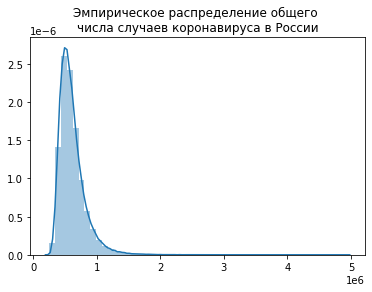

In [27]:
sns.distplot(total_samples);
plt.title('Эмпирическое распределение общего \nчисла случаев коронавируса в России');

In [28]:
print('Прогноз числа случаев коронавируса в пессимистичном сценарии:')
print('90-й процентиль в выборке числа случаев =', np.percentile(total_samples, 90))
print('Прогноз числа случаев коронавируса в оптимистичном сценарии:')
print('10-й процентиль в выборке числа случаев =', np.percentile(total_samples, 10))
print('Медианый прогноз =', np.percentile(total_samples, 50))

Прогноз числа случаев коронавируса в пессимистичном сценарии:
90-й процентиль в выборке числа случаев = 860783.3987427442
Прогноз числа случаев коронавируса в оптимистичном сценарии:
10-й процентиль в выборке числа случаев = 410105.2236295015
Медианый прогноз = 567109.0511137769


Рассмотренный выше способ построения эмпирического распределения количества общих случаев коронавируса представляется не совсем математически обоснованным. 

Второй способ: будем сэмплировать параметры линейной регрессии из найденного ранее многомерного нормального распределения, затем для каждого набора параметров будем генерировать ежедневные значения линейной регрессии с учетом шума для достаточно большого интервала времени (скажем, 365 дней), затем будем вычислять экспоненты, получая сэмплы ежедневных значений, и суммируем эти значения для всех дней. 

In [29]:
def sampleTotal2(mu_n_new_cases, sigma_n_new_cases, beta, n_samples=100000):
    days = 365
    X0 = np.ones(days).reshape(-1, 1)
    X = np.asarray(np.arange(days)).reshape(-1, 1)
    X = np.concatenate((X0, X, X ** 2), axis=1)
    w = np.random.multivariate_normal(mu_n_new_cases, sigma_n_new_cases, n_samples)
    pred = np.matmul(X, np.transpose(w)) + np.random.normal(0, np.sqrt(1/beta), (days, n_samples))
    return np.sum(np.exp(pred), axis=0)

In [30]:
total_samples = sampleTotal2(mu_n_new_cases, sigma_n_new_cases, beta_new_cases)

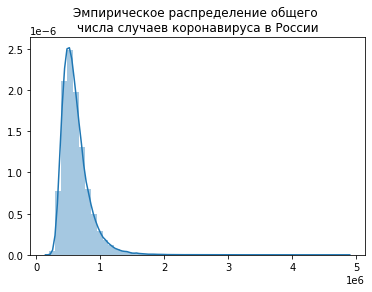

In [31]:
sns.distplot(total_samples);
plt.title('Эмпирическое распределение общего \nчисла случаев коронавируса в России');

In [32]:
print('Прогноз числа случаев коронавируса в пессимистичном сценарии:')
print('90-й процентиль в выборке числа случаев =', np.percentile(total_samples, 90))
print('Прогноз числа случаев коронавируса в оптимистичном сценарии:')
print('10-й процентиль в выборке числа случаев =', np.percentile(total_samples, 10))
print('Медианый прогноз =', np.percentile(total_samples, 50))

Прогноз числа случаев коронавируса в пессимистичном сценарии:
90-й процентиль в выборке числа случаев = 880382.76857167
Прогноз числа случаев коронавируса в оптимистичном сценарии:
10-й процентиль в выборке числа случаев = 397714.0705762999
Медианый прогноз = 567385.1428301316


Результаты второго способа близки к результатам первого.

Недостатки данной модели:

1. Из-за экспоненциальной зависимости в модели ошибки в линейной регрессии приводят к экспоненциальному росту ошибки прогноза. Поэтому прогноз по данной модели в начале эпидемии, когда количество новых случаев заболеваний еще далеко от максимума, очень неточен. 

2. Данная модель носит чисто эмпирический характер. Мы не знаем, как коэффициенты линейной регрессии связаны с заразностью вируса, характером социальных взаимодействий в обществе, состоянием популяционного иммунитета и т.п. Поэтому её очень трудно использовать для принятия решений о карантинных мерах.

3. Вызывает сомнение адекватность модели: данные по странам, где текущая вспышка идет на спад показывают, что снижение числа заболеваний идет гораздо медленнее, чем рост.